# Pipeline for the anomaly detection on the SKAB using LSTM-Autoencoder

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

In [ ]:
# libraries importing
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

sys.path.append("..")
from core.LSTM_AE import LSTM_AE
from core.metrics import chp_score
from core.utils import load_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
list_of_df, anomaly_free_df = load_skab()

## Method

### Method initialization

In [ ]:
# hyperparameters selection
EPOCHS = 100
BATCH_SIZE = 32
VAL_SPLIT = 0.1
N_STEPS = 10
Q = 0.99  # quantile for upper control limit (UCL) selection
PARAM = [EPOCHS, BATCH_SIZE, VAL_SPLIT]

In [ ]:
model = LSTM_AE(PARAM)

In [ ]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

### Method fitting and applying

In [ ]:
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(["anomaly", "changepoint"], axis=1)

    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)

    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)

    # model fitting
    # history, model = arch(X)
    model.fit(X)

    # results predicting
    residuals = pd.Series(
        np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1)
    )
    UCL = residuals.quantile(Q) * 3 / 2

    # results predicting
    X = create_sequences(
        StSc.transform(df.drop(["anomaly", "changepoint"], axis=1)), N_STEPS
    )
    cnn_residuals = pd.Series(
        np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1)
    )

    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results visualization

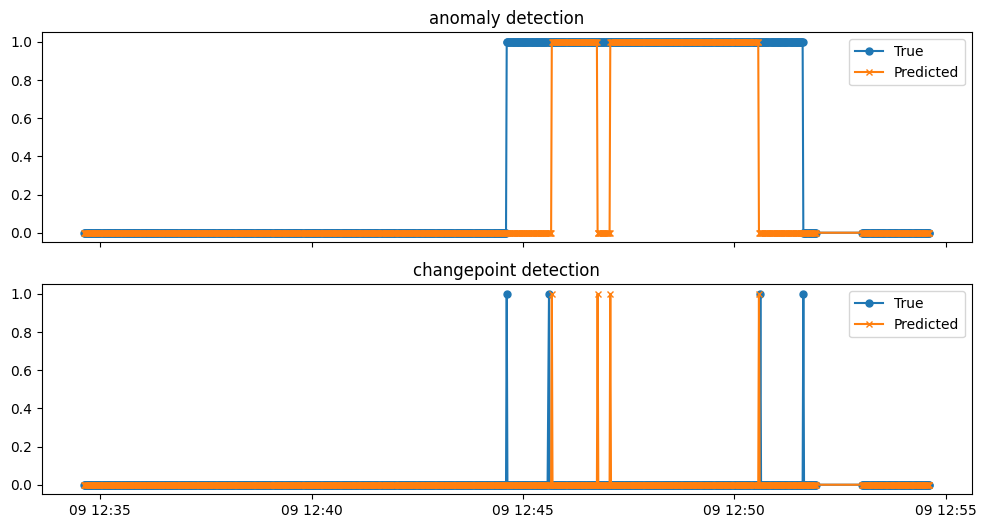

In [ ]:
# [donotremove]
true_outlier = [df.anomaly for df in list_of_df]
true_cp = [df.changepoint for df in list_of_df]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 13.65 %
Missing Alarm Rate 27.6 %
F1 metric 0.73


### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    anomaly_window_destination="righter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 129
A number of missed CPs = 74
A number of FPs = 20
Average time 0 days 00:01:13.974545454


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="30S",
    anomaly_window_destination="center",
)

Standard  -  13.77
LowFP  -  9.07
LowFN  -  17.97
